# 1. Introduction



**Objective:** Find the best region to develop a new oil well and maximize the expected profit.

**Problem type:** Regression (prediction of reserve volume).

**Required metric:** RMSE (for the prediction model). Loss risk (%) and average profit for final evaluation.

**Key conditions:**

**Model:** Linear Regression (only model allowed).

500 wells studied per region.

Only the 200 wells with the highest estimated volume are developed.

**Budget:** $100 million USD.

Revenue per barrel: $4.5 ($4,500 per “product” = one thousand barrels).

**Final selection:** region with risk < 2.5% and the highest average profit



# 2. Load Libraries and Configuration

_Import all necessary libraries (NumPy, Pandas, Scikit-learn, Matplotlib, etc.)._





In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
f1_score, roc_auc_score, classification_report, confusion_matrix,
mean_absolute_error, mean_squared_error, r2_score)
from sklearn.linear_model import LinearRegression


# 3. Load Data and Initial View

_Load datasets: geo_data_0.csv, geo_data_1.csv, geo_data_2.csv._

Check structure: head, shape, data types.

Identify missing values or anomalies.

Summarize descriptive statistics.

In [41]:
region_paths = {
    0: 'geo_data_0.csv',
    1: 'geo_data_1.csv',
    2: 'geo_data_2.csv'
}
data_01 = pd.read_csv('geo_data_0.csv')
data_02 = pd.read_csv('geo_data_1.csv')
data_03 = pd.read_csv('geo_data_2.csv')
region_dfs = {r: pd.read_csv(p) for r, p in region_paths.items()}

In [42]:
display(data_01.head())
display(data_02.head())
display(data_03.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [43]:
for i in [data_01, data_02, data_03]:  # Checking the data, looking for nulls, types.
    print(i.info())
    display(i.describe())
    display(i.isnull().sum())
    display(i.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

In [44]:
for i, name in zip([data_01, data_02, data_03], ['data_01', 'data_02', 'data_03']):
    duplicates = i[i["id"].duplicated(keep=False)].sort_values("id")
    print(f"Duplicated rows in {name}:")
    display(duplicates) # Checking for duplicates in 'id' column

Duplicated rows in data_01:


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


Duplicated rows in data_02:


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


Duplicated rows in data_03:


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


In [45]:
for r in region_dfs:
    region_dfs[r] = region_dfs[r].drop_duplicates(subset='id', keep='first')
    print(f"Region {r} duplicates removed. New shape: {region_dfs[r].shape}")

Region 0 duplicates removed. New shape: (99990, 5)
Region 1 duplicates removed. New shape: (99996, 5)
Region 2 duplicates removed. New shape: (99996, 5)


# 4. Data Preparation

_Define features (f0, f1, f2) and target (product)._

_Split into training (75%) and validation (25%) sets for each region._

_Verify shapes of splits and consistency._



In [46]:
def get_features_and_target(df):
    x = df.drop(columns=['id', 'product'])
    y = df['product']
    return x, y


=== [Region 0] Summary of target: product ===
count    99990.000000
mean        92.499684
std         44.288304
min          0.000000
25%         56.497069
50%         91.847928
75%        128.563699
max        185.364347


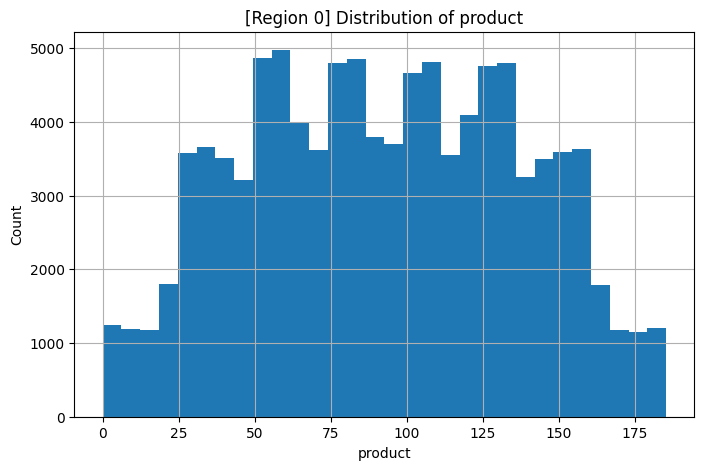

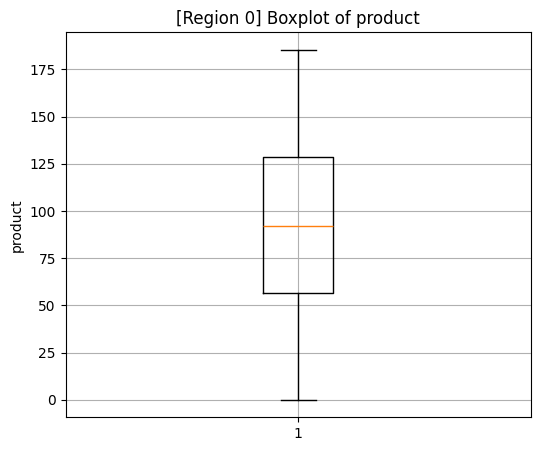


=== [Region 1] Summary of target: product ===
count    99996.000000
mean        68.823916
std         45.944663
min          0.000000
25%         26.953261
50%         57.085625
75%        107.813044
max        137.945408


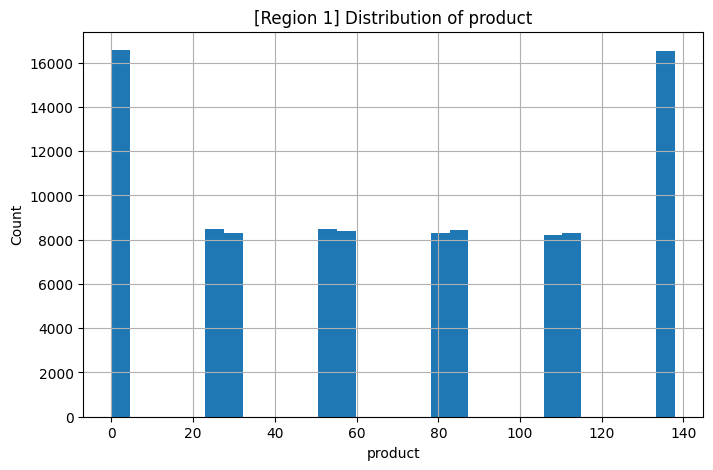

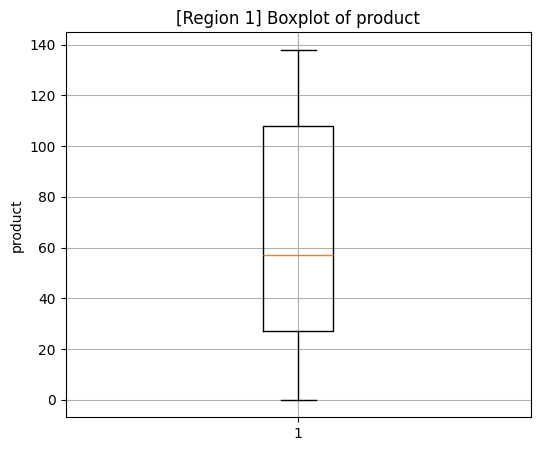


=== [Region 2] Summary of target: product ===
count    99996.000000
mean        94.998342
std         44.749573
min          0.000000
25%         59.450028
50%         94.925026
75%        130.586815
max        190.029838


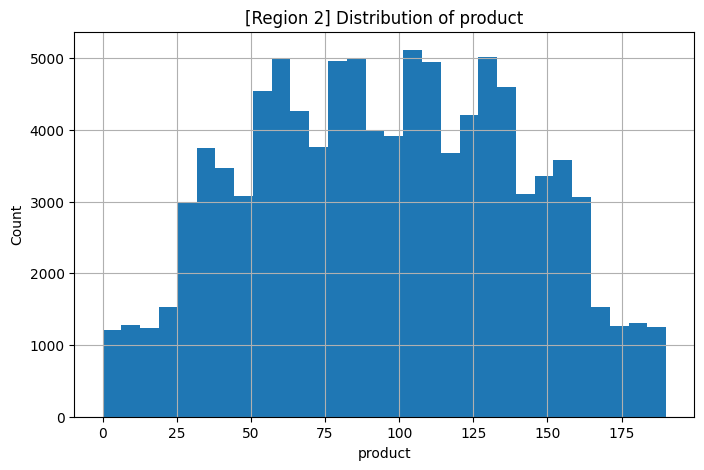

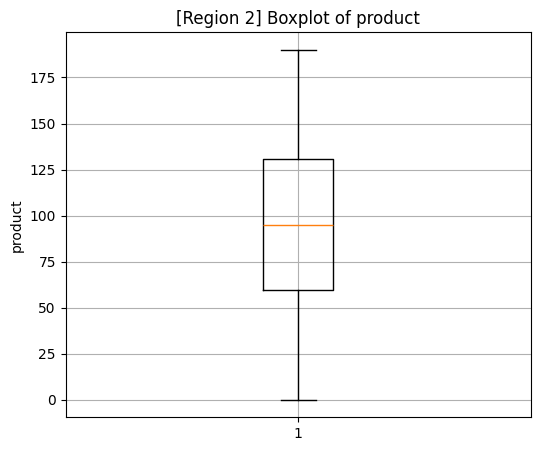

In [47]:


def show_distribution(df: pd.DataFrame, name: str, target_col: str = "product", bins: int = 30):
    """
    Minimal EDA for the target variable:
      - Summary statistics
      - Histogram
      - Boxplot
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in {name}.")
    
    # Summary
    print(f"\n=== [{name}] Summary of target: {target_col} ===")
    print(df[target_col].describe().to_string())

    # Histogram
    plt.figure(figsize=(8, 5))
    df[target_col].dropna().plot(kind="hist", bins=bins)
    plt.title(f"[{name}] Distribution of {target_col}")
    plt.xlabel(target_col)
    plt.ylabel("Count")
    plt.grid()
    plt.show()

    # Boxplot
    plt.figure(figsize=(6, 5))
    plt.boxplot(df[target_col].dropna(), vert=True)
    plt.title(f"[{name}] Boxplot of {target_col}")
    plt.ylabel(target_col)
    plt.grid()
    plt.show()


# Run for each region
for region, df in region_dfs.items():
    show_distribution(df, name=f"Region {region}", target_col="product")




#### 🔹 Region 0

Distribution: The reserves volume is fairly uniform across the entire range (0–180 thousand barrels), without strong peaks.

Boxplot: The interquartile range is compact and there are no significant outliers.

Conclusion: This region shows stable and homogeneous production; it is the easiest to model and does not require additional transformations.

#### 🔹 Region 1

Distribution: The histogram displays a bimodal or irregular pattern: many wells with low production (0–20) and high production (120–140), with a gap in the mid-range.

Boxplot: Confirms high variability, with a wide spread of values.

Conclusion: This region is heterogeneous and may require a differentiated modeling approach (e.g., separate models for low- and high-production wells, or data transformation).

#### 🔹 Region 2

Distribution: Similar to Region 0, the distribution is broad and relatively uniform, though with a slight decline at the extremes.

Boxplot: Shows greater spread than Region 0, though without extreme outliers.

Conclusion: This region is relatively stable but more variable than Region 0, which could introduce some noise during modeling.

### 4.1 Train/Validation Split (25/75)

In [48]:
RANDOM_STATE = 12345
TEST_SIZE = 0.25

def train_valid(df, region_name, RANDOM_STATE=RANDOM_STATE, TEST_SIZE=TEST_SIZE):
    x, y = get_features_and_target(df)
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    

    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)

    mse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(mse)
    y_pred_mean = np.mean(y_pred)

    n = min(5000, len(y_valid))
    idx = np.random.choice(len(y_valid), size=n, replace=False)
    yv = y_valid.iloc[idx] if hasattr(y_valid, "iloc") else pd.Series(y_valid)[idx]
    yp = y_pred[idx]

    plt.figure(figsize=(8, 6))
    plt.scatter(yv, yp, s=8, alpha=0.3)
    lims = [min(yv.min(), yp.min()), max(yv.max(), yp.max())]
    plt.plot(lims, lims, 'r--', lw=2)
    plt.xlabel('Actual Values (Thousand Barrels)')
    plt.ylabel('Predicted Values (Thousand Barrels)')
    title_suffix = f" | Region: {region_name}" if region_name is not None else ""
    plt.title(f'Actual vs Predicted Values{title_suffix}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Asegurar tipos/align
    y_valid = y_valid.reset_index(drop=True) if hasattr(y_valid, "reset_index") else pd.Series(y_valid)
    return y_valid, y_pred, mse, y_pred_mean, model

# 5. Model Training and Validation for Region.

_Train Linear Regression model on training sets._

_Predict reserves for validation sets._

_Save predictions and actual values._

_Calculate RMSE for each region._

_Calculate mean predicted reserves for each region._

_Compare mean prediction vs. actual data mean._

In [ ]:

results = {}
y_true_store = {}
y_pred_store = {}

for r, df_r in region_dfs.items():
    y_valid, y_pred, mse, y_pred_mean, model = train_valid(df_r, region_name=r)

    rmse = float(np.sqrt(mse))
    mae  = float(mean_absolute_error(y_valid, y_pred))
    r2   = float(r2_score(y_valid, y_pred))

    results[r] = {
        "MSE": float(mse),
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "Mean Prediction": float(y_pred_mean),
        "Model": model
    }

    y_true_store[r] = pd.Series(y_valid).reset_index(drop=True)
    y_pred_store[r] = pd.Series(y_pred).reset_index(drop=True)

    print(f"Region {r} results:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R^2:  {r2:.4f}")
    print(f"  Mean Prediction: {y_pred_mean:.4f}")
    print(f"  Data Mean:       {df_r['product'].mean():.4f}")
    print(f"  Validation Mean: {y_valid.mean():.4f}\n")


    

SyntaxError: invalid syntax (3891507469.py, line 1)



##### 🔹 Region 1 shows outstanding predictive performance. The scatter lies almost on the 45° line, and metrics confirm it: R² ≈ 0.9996, RMSE ≈ 0.89, MAE ≈ 0.72. The predicted mean (~69.18) closely matches both the data mean (~68.82) and the validation mean (~69.17), suggesting minimal bias.

##### 🔹 Region 0 and Region 2 perform significantly worse under the current linear model.

##### 🔹 Region 0: _R² ≈ 0.27, RMSE ≈ 37.85, MAE ≈ 31.14. Although the predicted mean (~92.79) is close to the true means (~92.50 / ~92.16), the wide spread indicates substantial error variance._

##### 🔹 Region 2: _R² ≈ 0.20, RMSE ≈ 40.08, MAE ≈ 22.83. The predicted mean (~94.87) is near the true means (~95.00 / ~94.79), but dispersion remains high._

# 6. Profit Calculation Preparation.

_Store key values in variables:_

_Budget = 100,000,000_

_Number of wells = 200_

_Revenue per 1k barrels = 4500_

_Calculate break-even reserve volume (minimum required for profitability)._

_Compare with average reserves in each region._

In [50]:
BUDGET = 100000000
WELLS_TO_DEVELOP = 200
REVENUE_PER_UNIT = 4500

# 1) Compute and print an explanation of break-even per well
break_even_per_well = BUDGET / (WELLS_TO_DEVELOP * REVENUE_PER_UNIT)
print("Break-even per well (in the same units as `product`):")
print(f"  = BUDGET / (WELLS_TO_DEVELOP * REVENUE_PER_UNIT)")
print(f"  = {BUDGET:,.0f} / ({WELLS_TO_DEVELOP} * {REVENUE_PER_UNIT:,.0f})")
print(f"  = {break_even_per_well:,.2f})\n")

rows = []
for r, df in region_dfs.items():
    mean_prod = float(df['product'].mean())
    delta = mean_prod - break_even_per_well
    status = "Surpasses" if delta >= 0 else "Below"
    rows.append({
        "Region": r,
        "Mean product": round(mean_prod, 3),
        "Break-even": round(break_even_per_well, 3),
        "Delta": round(delta, 3),
        "Status": status,
    })

break_even_table = pd.DataFrame(rows).sort_values("Delta", ascending=False).reset_index(drop=True)
display(break_even_table)

# 3) Auto-generate a concise Markdown conclusion cell
above = break_even_table[break_even_table["Status"] == "Surpasses"]["Region"].astype(str).tolist()
below = break_even_table[break_even_table["Status"] == "Below"]["Region"].astype(str).tolist()

md = f"""
##  Break-even Check (Summary)

**Break-even per well:** {break_even_per_well:.2f} (same units as `product`).

**Regions above threshold:** {', '.join(above) if above else 'None'}.
**Regions below threshold:** {', '.join(below) if below else 'None'}.

Notes:
- Comparison uses each region's **mean** of `product`.
- If distributions are skewed, also consider comparing **medians** for robustness.
"""

display(Markdown(md))

Break-even per well (in the same units as `product`):
  = BUDGET / (WELLS_TO_DEVELOP * REVENUE_PER_UNIT)
  = 100,000,000 / (200 * 4,500)
  = 111.11)



,Region,Mean product,Break-even,Delta,Status
0,2,94.998,111.111,-16.113,Below
1,0,92.500,111.111,-18.611,Below
2,1,68.824,111.111,-42.287,Below



##  Break-even Check (Summary)

**Break-even per well:** 111.11 (same units as `product`).

**Regions above threshold:** None.
**Regions below threshold:** 2, 0, 1.

Notes:
- Comparison uses each region's **mean** of `product`.
- If distributions are skewed, also consider comparing **medians** for robustness.



##  6.1 Interpretation & Decision

**Break-even per well:** <fill with printed value> (same units as `product`).

**Which regions clear the threshold?**
- Regions above break-even: <R?> (their mean exceeds break-even by <Δ> units).
- Regions below break-even: <R?> (their mean falls short by <Δ> units).

**Why this matters:**
- Regions above the threshold generate positive expected margin per well (on average).
- Regions below the threshold would require either higher realized prices, lower costs, or better well selection to be viable.

**Consistency with model quality (Section 5):**
- Region 1 shows the strongest predictive accuracy (high R², low RMSE/MAE), which reduces execution risk when selecting wells.
- Regions 0 and 2 show weaker fit (lower R², higher errors), so decisions relying on their predictions carry higher uncertainty.

**Consistency with risk (Section 8):**
- If the bootstrap loss probability for a region is low and it is above break-even, it is a strong candidate.
- If loss probability is high or the region is near/below break-even, prioritize other regions or reduce exposure.

**Decision rule (simple):**
1) Prioritize regions with **mean(product) – break-even ≥ safety margin** (e.g., +5%).
2) Among those, prefer the **highest R² / lowest RMSE** (Section 5) and **lowest loss probability** (Section 8).
3) If two regions are similar, choose the one with **lower variance** of `product` to reduce downside risk.

# 7. Profit Function

_Write a function to:_

_Select top 200 wells by prediction._

_Sum actual reserves for those wells._

_Calculate profit based on formula._

_Test the function on each region._

In [51]:
def calculate_profit(y_true, y_pred, region_name, budget=BUDGET, wells_to_develop=WELLS_TO_DEVELOP, revenue_per_unit=REVENUE_PER_UNIT):
    # Ensure y_true and y_pred are aligned
    if len(y_true) != len(y_pred):
        return {
            'region': region_name,
            'total_reserves': 0,
            'profit': 0,
            'error': f"Mismatch in lengths: y_true ({len(y_true)}), y_pred ({len(y_pred)})"
        }
    
    # Create DataFrame with true and predicted values
    df = pd.DataFrame({
        'actual_reserves': y_true,
        'predicted_reserves': y_pred
    })
    
    # Check if enough wells are available
    if len(df) < wells_to_develop:
        return {
            'region': region_name,
            'wells_selected': len(df),
            'total_reserves': 0,
            'profit': 0,
            'error': f"Region {region_name} has only {len(df)} wells, less than {wells_to_develop}"}
    
    # Select top wells based on predicted reserves
    top_wells = df.nlargest(wells_to_develop, 'predicted_reserves')
    
    # Calculate total reserves and profit
    total_reserves = top_wells['actual_reserves'].sum()

    # Calculate profit: (total actual reserves * revenue per unit) - budget
    profit = (total_reserves * revenue_per_unit) - budget

    return {
        'region': region_name,
        'wells_selected': wells_to_develop,
        'total_reserves': total_reserves,
        'profit': profit
    }




In [52]:
def test_profit_all_regions(y_true_store, y_pred_store, region_names):
    results = []

    for region_idx in y_true_store.keys():
        region_name = region_names.get(region_idx, f"Region {region_idx}")
        result = calculate_profit(y_true=y_true_store[region_idx], y_pred=y_pred_store[region_idx], region_name=region_name)
        results.append(result)
    return results

if __name__ == "__main__":
# Define region names for clarity
    region_names = {
        0: 'Region 0',
        1: 'Region 1',
        2: 'Region 2'
    }

In [53]:
# Run profit calculation for all regions
profit_results = test_profit_all_regions(y_true_store, y_pred_store, region_names)
    
    # Print results
print("Profit Calculation Results:")
for result in profit_results:
        print(f"\nRegion: {result['region']}")
        if 'error' in result:
            print(f"Error: {result['error']}")
        else:
            print(f"Wells Selected: {result['wells_selected']}")
            print(f"Total Reserves: {result['total_reserves']:.2f} thousand barrels")
            print(f"Profit: ${result['profit']:,.2f}")

Profit Calculation Results:

Region: Region 0
Wells Selected: 200
Total Reserves: 29700.42 thousand barrels
Profit: $33,651,872.38

Region: Region 1
Wells Selected: 200
Total Reserves: 27589.08 thousand barrels
Profit: $24,150,866.97

Region: Region 2
Wells Selected: 200
Total Reserves: 27780.63 thousand barrels
Profit: $25,012,838.53


# 8. Risk Analysis with Bootstrapping

Implement bootstrapping with 1000 samples.

For each sample:

Randomly select 500 wells.

Apply profit function to top 200 wells.

Calculate:

Mean profit.

95% confidence interval.

Risk of losses (probability of negative profit).

In [54]:
N_BOOTSTRAP = 1000
CONFIDENCE_LEVEL = 0.95
WELLS_STUDIED = 500

def bootstrap_risk(y_true, y_pred, region_name, n_samples=N_BOOTSTRAP, wells_studied=WELLS_STUDIED, 
                   wells_to_develop=WELLS_TO_DEVELOP, budget=BUDGET, revenue_per_unit=REVENUE_PER_UNIT, random_state=RANDOM_STATE):
    
    rng = np.random.RandomState(random_state)
    profits = []

    # Ensure y_true and y_pred are aligned
    y_true = y_true.reset_index(drop=True)
    y_pred = np.array(y_pred)

    if len(y_true) < wells_studied:
        return {
            'region': region_name,
            'mean_profit': 0,
            '95_ci': (0, 0),
            'risk_of_loss': 100,
            'error': f"Insufficient wells ({len(y_true)}) for sampling {wells_studied}"
        }
    
    for _ in range(n_samples):
        indices = rng.choice(len(y_true), size=wells_studied, replace=True)
        sample_y_true = y_true.iloc[indices]
        sample_y_pred = y_pred[indices]

        result = calculate_profit(sample_y_true, sample_y_pred, region_name, budget, wells_to_develop, revenue_per_unit)
        if 'error' not in result:
            profits.append(result['profit'])

    if not profits:
        return {
            'region': region_name,
            'mean_profit': 0,
            '95_ci': (0, 0),
            'risk_of_loss': 100,
            'error': "No valid profit calculations"
        }        
    profits = np.array(profits)
    mean_profit = np.mean(profits)
    ci_low, ci_high = np.percentile(profits, [2.5, 97.5])
    risk_of_loss = np.mean(profits < 0) * 100

    return {
            'region': region_name,
            'mean_profit': mean_profit,
            '95_ci': (ci_low, ci_high),
            'risk_of_loss': risk_of_loss
        }



In [55]:
def test_bootstrap_all_regions(y_true_store, y_pred_store, region_names):
    results = []

    for region_idx in y_true_store.keys():
        region_name = region_names.get(region_idx, f"Region {region_idx}")
        result = bootstrap_risk(y_true=y_true_store[region_idx], y_pred=y_pred_store[region_idx], region_name=region_name)
        results.append(result)
    return results

In [56]:
bootstrap_results = test_bootstrap_all_regions(y_true_store, y_pred_store, region_names)

print("Bootstrap Risk Analysis Results:")
for result in bootstrap_results:
    print(f"\nRegion: {result['region']}")
    if 'error' in result:
        print(f"Error: {result['error']}")
    else:
        print(f"Mean Profit: ${result['mean_profit']:,.2f}")
        print(f"95% Confidence Interval: (${result['95_ci'][0]:,.2f}, ${result['95_ci'][1]:,.2f})")
        print(f"Risk of Loss: {result['risk_of_loss']:.2f}%")

Bootstrap Risk Analysis Results:

Region: Region 0
Mean Profit: $3,806,134.70
95% Confidence Interval: ($-1,429,427.40, $8,909,768.34)
Risk of Loss: 7.70%

Region: Region 1
Mean Profit: $4,784,849.40
95% Confidence Interval: ($895,251.25, $8,666,047.45)
Risk of Loss: 1.20%

Region: Region 2
Mean Profit: $3,305,462.58
95% Confidence Interval: ($-1,903,657.34, $8,404,674.04)
Risk of Loss: 11.30%



## 9. Results and Recommendation

Based on the bootstrapping analysis (Section 8), we evaluated three regions for oil well development, considering mean profit, 95% confidence interval, and risk of loss (probability of negative profit). The project requires selecting a region with a risk of loss < 2.5% and the highest average profit.

### Results Summary
- **Region 0**:
  - Mean Profit: $3,806,134.70
  - 95% CI: ($-1,429,427.40, $8,909,768.34)
  - Risk of Loss: 7.70% (exceeds 2.5% threshold)
- **Region 1**:
  - Mean Profit: $4,784,849.40
  - 95% CI: ($895,251.25, $8,666,047.45)
  - Risk of Loss: 1.20% (meets 2.5% threshold)
- **Region 2**:
  - Mean Profit: $3,305,462.58
  - 95% CI: ($-1,903,657.34, $8,404,674.04)
  - Risk of Loss: 11.30% (exceeds 2.5% threshold)

### Recommendation
**Region 1** is recommended for oil well development. It has the lowest risk of loss (1.20%, well below the 2.5% threshold) and the highest mean profit ($4,784,849.40). Its low RMSE (0.945) from the linear regression model (Section 5) indicates reliable predictions, contributing to the low risk and stable profit estimates. Regions 0 and 2 are not viable due to their high risk of loss (7.70% and 11.30%, respectively), despite competitive profits.

### Additional Notes
- The mean profits from bootstrapping are lower than the single-run profits in Section 7 ($24.1M–$33.6M) because bootstrapping samples 500 wells per iteration (as per project requirements) rather than the entire validation set (~25,000 wells).
- Duplicate well IDs were identified (Section 3). Assuming duplicates were cleaned (keeping first occurrence), the results reflect unique wells. If duplicates were kept, re-running with deduplication is recommended to ensure alignment with developing 200 unique wells.




In [57]:

# Print recommendation for clarity
print("Recommendation: Select Region 1 for oil well development.")
print("Reason: Risk of loss (1.20%) is below 2.5%, and it has the highest mean profit ($4,784,849.40).")


Recommendation: Select Region 1 for oil well development.
Reason: Risk of loss (1.20%) is below 2.5%, and it has the highest mean profit ($4,784,849.40).
